This notebook is an illustration of transfer learning. It uses:
- a pre-trained Model from Keras (Xception)
- a dataset of casting products, some of which have a defect
Then it adds a simple classification layer to the pre-trained model, and trains it with the pictures.

The code is adapted from: 
- Keras tutorial https://keras.io/guides/transfer_learning/
- Kaggle tutorial https://www.kaggle.com/code/digantdixit/transfer-learning-cnn-for-beginners

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow, os, keras
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential

In [8]:
train_data_gen = image.ImageDataGenerator(rescale=1.0 / 255, validation_split=0.2)
train = train_data_gen.flow_from_directory(
    directory="casting_512x512/",
    target_size=(256, 256),
    batch_size=32,
    class_mode="binary",
    subset="training",
)
test = train_data_gen.flow_from_directory(
    directory="casting_512x512/",
    target_size=(256, 256),
    batch_size=32,
    class_mode="binary",
    subset="validation",
)

Found 1041 images belonging to 2 classes.


Found 259 images belonging to 2 classes.


In [9]:
print(train.class_indices)
print(test.class_indices)

{'def_front': 0, 'ok_front': 1}
{'def_front': 0, 'ok_front': 1}


In [10]:
from tensorflow.keras.applications import Xception

xcept = Xception(input_shape=(256, 256, 3), include_top=False, weights="imagenet")

In [6]:
# Alternative code to build the transfer model, adapted from Kaggle
# for layer in xcept.layers:
#    layer.trainable = False
# model=keras.Sequential([
#    xcept,
#    keras.layers.Flatten(),
#    keras.layers.Dense(units=256, activation="relu"),
#    keras.layers.Dropout(0.2),
#    keras.layers.Dense(units=1, activation="sigmoid"),
# ])

# model.compile(optimizer="adam",loss='binary_crossentropy',metrics=['accuracy'])

In [11]:
# Adapted code from Keras transfer learning tutorial
xcept.trainable = False
inputs = keras.Input(shape=(256, 256, 3))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`.
x = xcept(inputs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with a single unit (binary classification)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

In [12]:
print(model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception (Functional)           │ (None, 8, 8, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,863,529 (79.59 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 20,861,480 (79.58 MB)

None


In [13]:
model.fit(
    train,
    epochs=10,
    steps_per_epoch=7,
    validation_data=test,
    validation_steps=len(test),
)

Epoch 1/10


/home/rbonhomme001/Documents/Cours/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1732263606.793175   67364 service.cc:148] XLA service 0x76313c003d10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732263606.793198   67364 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-11-22 09:20:06.878588: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1732263607.434755   67364 cuda_dnn.cc:529] Loaded cuDNN version 90300


1/7 ━━━━━━━━━━━━━━━━━━━━ 1:05 11s/step - accuracy: 0.2500 - loss: 1.0232

I0000 00:00:1732263614.484140   67364 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


7/7 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.4724 - loss: 0.8288 - val_accuracy: 0.6023 - val_loss: 0.6812
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step - accuracy: 0.5288 - loss: 0.7190 - val_accuracy: 0.6023 - val_loss: 0.6082
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step - accuracy: 0.6235 - loss: 0.5853 - val_accuracy: 0.6448 - val_loss: 0.5795
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step - accuracy: 0.6434 - loss: 0.5610 - val_accuracy: 0.6757 - val_loss: 0.5567
Epoch 5/10
5/7 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.7645 - loss: 0.4727

/home/rbonhomme001/Documents/Cours/.venv/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step - accuracy: 0.7639 - loss: 0.4685 - val_accuracy: 0.6873 - val_loss: 0.5446
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step - accuracy: 0.7170 - loss: 0.5216 - val_accuracy: 0.6911 - val_loss: 0.5319
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step - accuracy: 0.7601 - loss: 0.4514 - val_accuracy: 0.7066 - val_loss: 0.5184
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step - accuracy: 0.6334 - loss: 0.5575 - val_accuracy: 0.7066 - val_loss: 0.5079
Epoch 9/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step - accuracy: 0.7215 - loss: 0.4857 - val_accuracy: 0.7143 - val_loss: 0.4914
Epoch 10/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step - accuracy: 0.7722 - loss: 0.4815 - val_accuracy: 0.7143 - val_loss: 0.4870


In [14]:
print(model.history.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


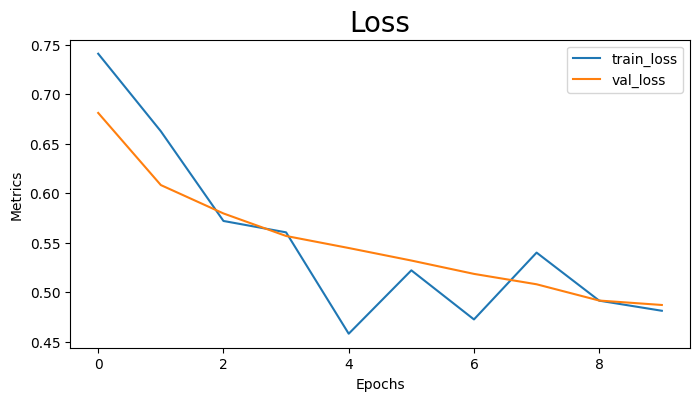

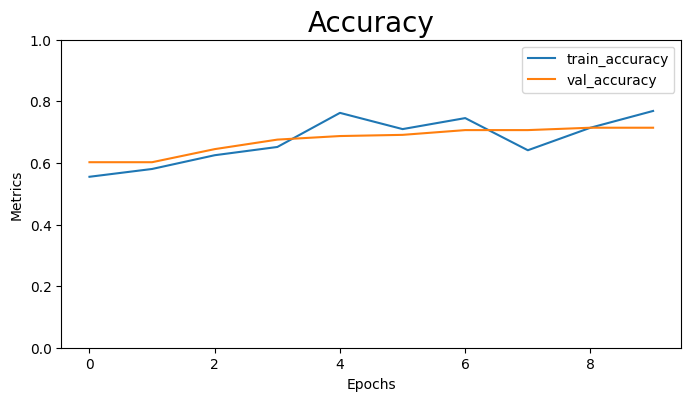

In [15]:
# plot loss
plt.subplots(figsize=(8, 4))
X = range(1, 1 + len(model.history.epoch))
plt.plot(model.history.history["loss"])
plt.plot(model.history.history["val_loss"])
plt.title("Loss", fontsize=20)
plt.xlabel("Epochs")
plt.ylabel("Metrics")
plt.legend(labels=["train_loss", "val_loss"])
plt.show()

# plot accuracy
plt.subplots(figsize=(8, 4))
plt.plot(model.history.history["accuracy"])
plt.plot(model.history.history["val_accuracy"])
plt.title("Accuracy", fontsize=20)
plt.xlabel("Epochs")
plt.ylabel("Metrics")
plt.ylim(0, 1)
plt.legend(labels=["train_accuracy", "val_accuracy"])
plt.show()

Ideas of possible variations to see how performance changes:
- try using data augmentation
- try using fine-tuning
- try other pretrained models (resnet, mobilenet)
- try a lower number of input images 




Alternative idea: if we don't want to use transfer learning, we can also use raw classifications from the pre-trained model as a proxy metric to ok/defect

In [16]:
# Incomplete code, To finish - zero-shot prediction on all images to see what comes out
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.xception import preprocess_input, decode_predictions
import numpy as np

model = Xception(input_shape=(299, 299, 3), weights="imagenet")

img_path = "casting_512x512/ok_front/cast_ok_0_1018.jpeg"
# img_path = 'casting_512x512/def_front/cast_def_0_0.jpeg'
img = image.load_img(img_path, target_size=(299, 299))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = model.predict(x)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
print("Predicted:", decode_predictions(preds, top=3)[0])

91884032/91884032 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
Predicted: [('n03843555', 'oil_filter', 0.3106175), ('n04553703', 'washbasin', 0.22474818), ('n04019541', 'puck', 0.09050678)]
